In [1]:

!pip install -q scikit-learn matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib   # for saving model
print("Imports done. sklearn version:", __import__("sklearn").__version__)


Imports done. sklearn version: 1.6.1


In [3]:
# STEP 2: Load dataset

# 🔹 Change this flag to False if you want to upload your own dataset
use_builtin = True   # True = use Breast Cancer dataset; False = upload your own CSV

if use_builtin:
    data = datasets.load_breast_cancer()
    X = data.data
    y = data.target
    feature_names = data.feature_names
    print("✅ Loaded built-in Breast Cancer dataset")
    print("Shape of X:", X.shape, "Shape of y:", y.shape)

else:
    print("📂 Please select your CSV file...")
    uploaded = files.upload()  # Choose your dataset file
    csv_path = list(uploaded.keys())[0]
    df = pd.read_csv(csv_path)

    print("✅ File uploaded:", csv_path)
    print("Preview of your dataset:")
    display(df.head())

    # 🔹 Option 1: If your target (label) is the last column
    # X = df.iloc[:, :-1].values
    # y = df.iloc[:, -1].values

    # 🔹 Option 2: If your target column has a specific name (e.g. "Outcome" or "target")
    target_col = df.columns[-1]   # Change this if your label is in another column
    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    print("✅ Data loaded successfully")
    print("Shape of X:", X.shape, "Shape of y:", y.shape)


✅ Loaded built-in Breast Cancer dataset
Shape of X: (569, 30) Shape of y: (569,)


In [4]:
# STEP 3: Split and scale data
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Data preprocessed")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


✅ Data preprocessed
Train shape: (455, 30) Test shape: (114, 30)


In [5]:
# STEP 4: Linear SVM
linear_svm = SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE)
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)

print("=== Linear SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_linear))
print("Classification report:\n", classification_report(y_test, y_pred_linear))


=== Linear SVM Results ===
Accuracy: 0.9736842105263158
Confusion matrix:
 [[41  1]
 [ 2 70]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [6]:
# STEP 5: RBF SVM
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_STATE)
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)

print("=== RBF SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rbf))
print("Classification report:\n", classification_report(y_test, y_pred_rbf))


=== RBF SVM Results ===
Accuracy: 0.9824561403508771
Confusion matrix:
 [[41  1]
 [ 1 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



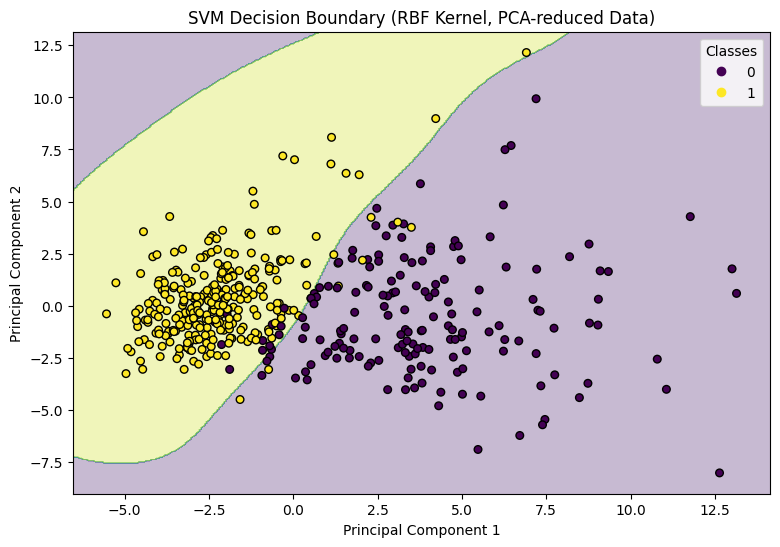

In [7]:
# STEP 6: Visualization using PCA (for 2D plot)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

svm_vis = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_STATE)
svm_vis.fit(X_train_2d, y_train)

# Create meshgrid
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))

Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(9,6))
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, s=30, edgecolors='k')
plt.title("SVM Decision Boundary (RBF Kernel, PCA-reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


In [8]:
# STEP 7: Tune hyperparameters (C & gamma)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(SVC(random_state=RANDOM_STATE), param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)
print("Best Cross-validation Accuracy:", grid.best_score_)

best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test)

print("\n=== Tuned RBF SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification report:\n", classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
✅ Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-validation Accuracy: 0.9758241758241759

=== Tuned RBF SVM Results ===
Accuracy: 0.9824561403508771
Confusion matrix:
 [[41  1]
 [ 1 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [9]:
# STEP 8: Cross-validation + Save model
cv_scores = cross_val_score(best_svm, np.vstack([X_train, X_test]),
                            np.hstack([y_train, y_test]), cv=cv, scoring='accuracy', n_jobs=-1)
print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean(), "±", cv_scores.std())

# Save models and scaler
joblib.dump(best_svm, "/content/best_svm_model.joblib")
joblib.dump(scaler, "/content/scaler.joblib")
joblib.dump(pca, "/content/pca.joblib")
print("✅ Model, scaler, and PCA saved to /content/")



Cross-validation Scores: [1.         0.97368421 0.97368421 0.98245614 0.97345133]
Mean Accuracy: 0.9806551777674274 ± 0.010262064525444191
✅ Model, scaler, and PCA saved to /content/
